# Badanie Korelacji i selekcja cech

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from tqdm import tqdm
import math


In [13]:
df = pd.read_csv("sp500/data_xy.csv").set_index(keys=['quarter', 'ticker'])
not_relevant_features = pd.read_csv('sp500/target.csv').set_index(keys=['date', 'ticker']).columns.to_list()
features = list(set(df.columns) - set(not_relevant_features))

target_features = [
    "log_return_q1",
    "log_return_q2",
    "log_return_q3",
    "log_return_q4",
    "diff_q1",
    "diff_q2",
    "diff_q3",
    "diff_q4",
]

In [14]:
def correlation_matrix(df, val):
    corr_matrix = pd.DataFrame(
        data = {
            "ticker": [],
            "feature": [],
            "p-value": [],
            "correlation": []
        }
    ).set_index(keys=['ticker', 'feature'])
    num_of_companies = len(df['ticker'].unique())
    num_of_features = len(features)
    for i in tqdm(range(num_of_features)):
        feature = features[i]
        significant_count = 0
        significant_tickers = []
        feature_correlations = []
        for ticker in df['ticker'].unique():

            ticker_data = df[df['ticker'] == ticker]
            x = ticker_data[feature]
            y = ticker_data[val]
            if len(ticker_data[feature]) > 1 and (x != x.iloc[0]).any() and (y != y.iloc[0]).any():
                corr, p_value = stats.pearsonr(x, y)
                corr_matrix.loc[(ticker, feature), 'p-value'] = p_value
                corr_matrix.loc[(ticker, feature), 'correlation'] = corr
    return corr_matrix

In [ ]:
import warnings
warnings.filterwarnings("ignore")

HORIZON = 4

correlation_data = dict()
features_for_correlations = [f'log_return_q{i}' for i in range(1, HORIZON + 1)] + [f'diff_q{i}' for i in range(1, HORIZON + 1)]

for target_feature in features_for_correlations:
    print(target_feature)
    dff = df.dropna(subset = [target_feature]).reset_index()
    correlation_data[target_feature] = correlation_matrix(dff, val=target_feature)
    correlation_data[target_feature].to_csv(f'sp500/features_correlation_{target_feature}.csv')

log_return_q1


 57%|█████▋    | 393/691 [14:10<17:40,  3.56s/it]

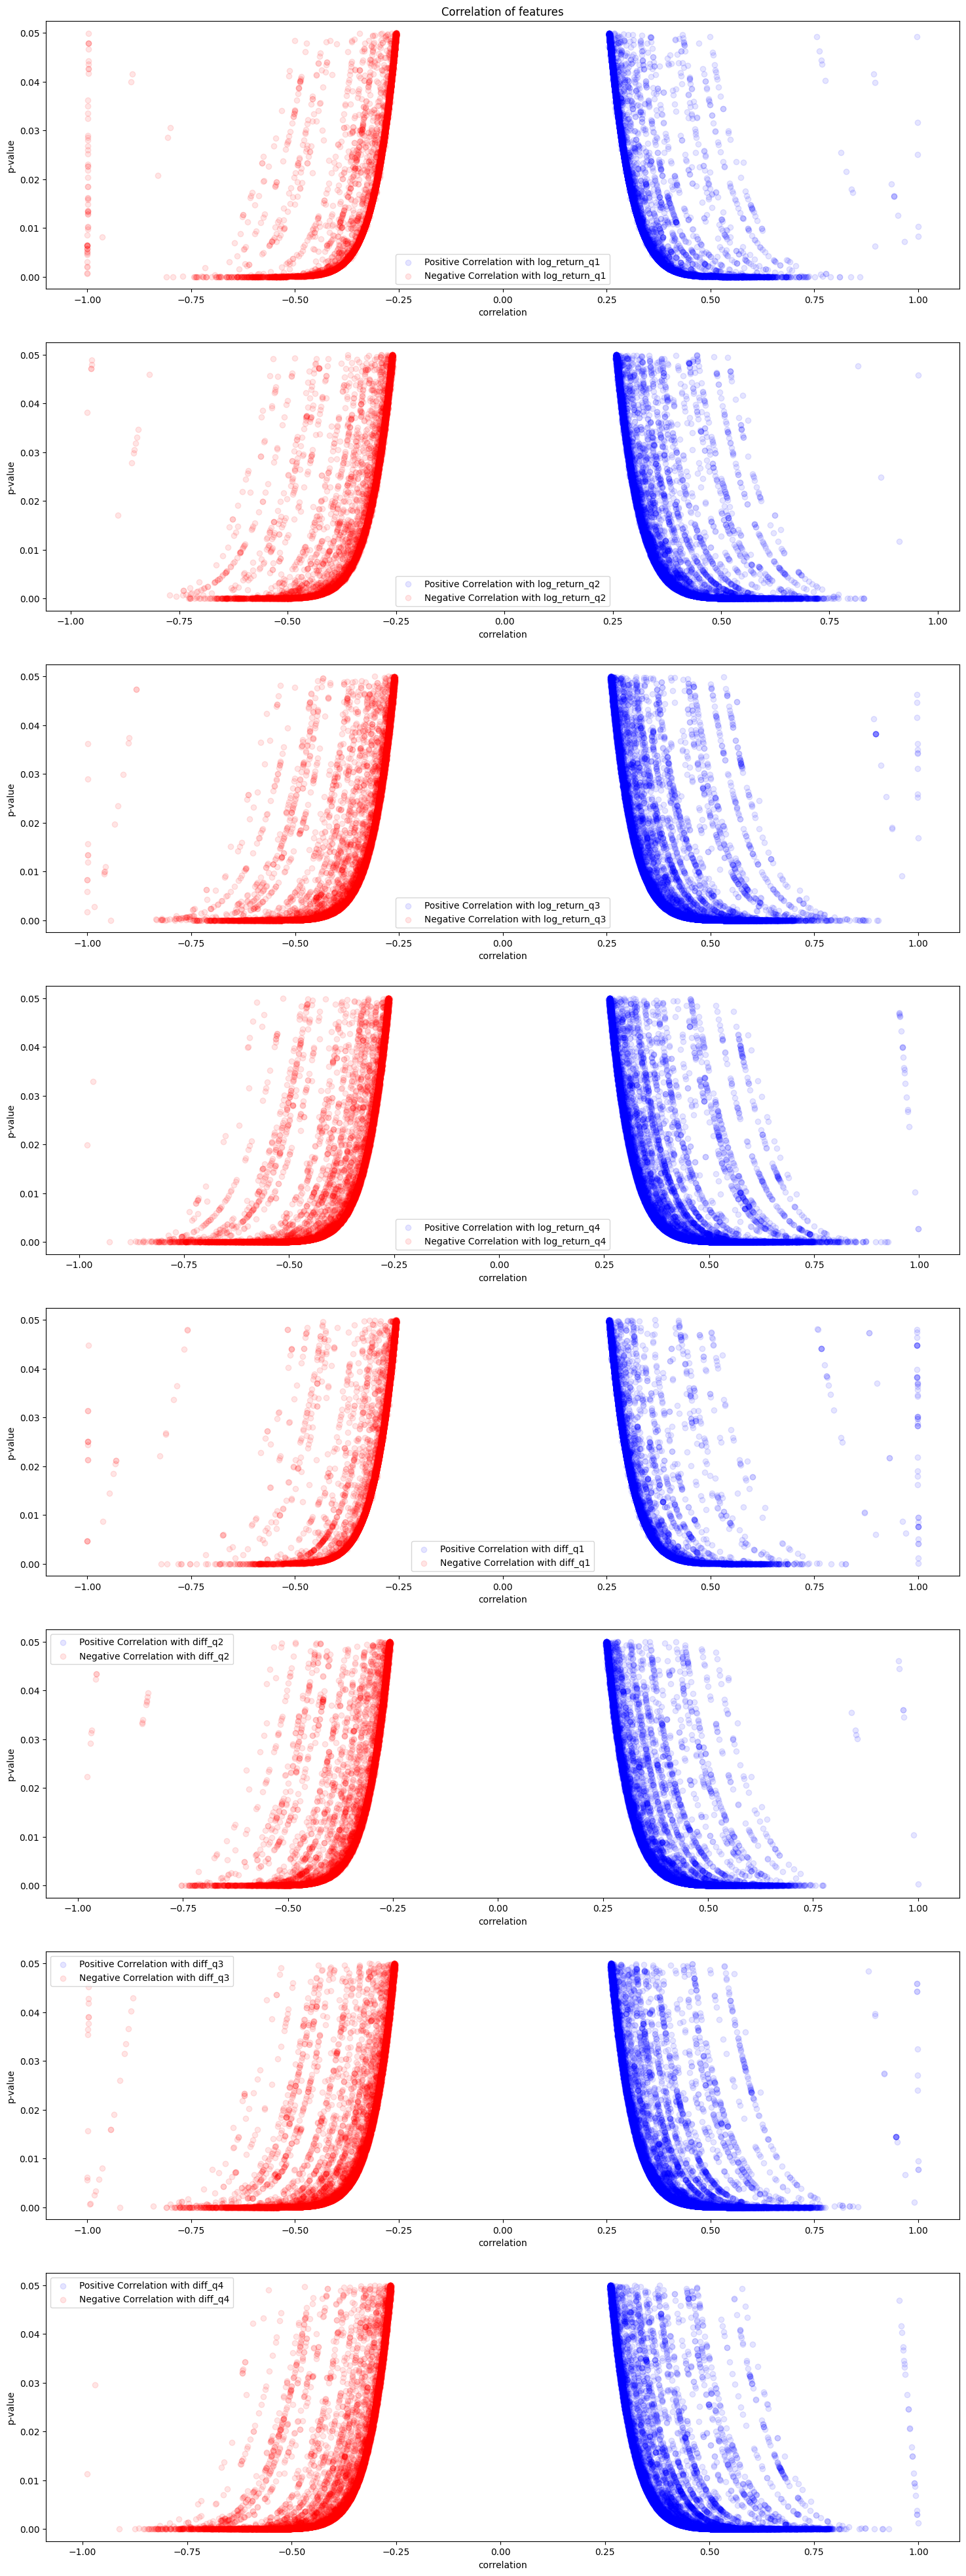

In [382]:
def plot_correlation(data):
    fig, axs = plt.subplots(len(data), 1)

    for i, col in enumerate(data.keys()):
        x = data[col].dropna()
        x = x.loc[x['p-value'] < 0.05]
        positive_df = x.loc[x['correlation'] > 0]
        negative_df = x.loc[x['correlation'] < 0]
        axs[i].scatter(positive_df['correlation'], positive_df['p-value'], c='blue', label=f'Positive Correlation with {col}', alpha=0.1)
        axs[i].scatter(negative_df['correlation'], negative_df['p-value'], c='red', label=f'Negative Correlation with {col}', alpha=0.1)
        axs[i].set_xlabel('correlation')
        axs[i].set_ylabel('p-value')

        axs[i].legend()
    axs[0].set_title('Correlation of features')
    fig.set_figheight(50)
    fig.set_figwidth(18)

plot_correlation(correlation_data)

In [ ]:
def analyze_features(df):
    features = df['feature'].unique()
    results = []
    
    total_companies = len(df['ticker'].unique())
    
    for feature in features:
        feature_data = df[df['feature'] == feature]
        significant_results = feature_data[feature_data['p-value'] < 0.05]

        neg = len(significant_results.loc[significant_results['correlation'] < 0.0])
        pos = len(significant_results.loc[significant_results['correlation'] > 0.0])

        significance_ratio = len(significant_results) / total_companies
        avg_correlation = significant_results['correlation'].mean()
        
        results.append({
            'feature': feature,
            'significance': significance_ratio,
            'avg_correlation_significant': avg_correlation,
            'csi': (pos-neg)/(pos+neg) if (pos+neg) else 0.0,
            'abs(csi)': abs((pos-neg)/(pos+neg)) if (pos+neg) else 0.0,

        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('significance', ascending=False)
    
    return results_df


In [ ]:
analyzed_features = {}

for k in correlation_data:
    print(k)
    x = analyze_features(correlation_data[k].reset_index())
    x = x.dropna()
    x = x.sort_values(by=['significance', 'abs(csi)'], ascending=False)
    analyzed_features[k] = x
    selected_features = x.loc[x['significance']> 0.12].loc[x['abs(csi)']> 0.6]['feature'].to_list()
    print(len(selected_features))


log_return_q1
42
log_return_q2
205
log_return_q3
224
log_return_q4
220
diff_q1
40
diff_q2
186
diff_q3
200
diff_q4
174


In [432]:
x = analyzed_features['log_return_q3']
x = x.loc[x['significance']> 0.27].loc[x['abs(+/-)']> 0.6]
f1 = x['feature'].to_list()
len(f1)

43

In [ ]:
import re
from collections import defaultdict
similar_features = defaultdict(list)

x = analyzed_features['diff_q3']
x = x.loc[x['significance']> 0.3].loc[x['abs(+/-)']> 0.7]
f2 = x['feature'].to_list()


def reduce_features_set(features_set, df):
    for feat in features_set:
        prefix = re.split(r'_\d+_', feat)[0]
        similar_features[prefix].append(feat)

    selected_features = []
    for i, k in enumerate(similar_features):
        if len(similar_features[k]) > 1:    
            similar_features_to_select = []
            for f in similar_features[k]:
                s = df.loc[df['feature']== feat][['significance', 'avg_correlation_significant', '+/-', 'abs(+/-)']].values[0][1]
                similar_features_to_select.append((feat, s))
            selected = max(similar_features_to_select, key=lambda x:x[1])[0]
            selected_features.append(selected)
        else:
            selected_features.append(k)
    return selected_features

x.loc[x['feature'].isin(selected_features)]


,feature,significance,avg_correlation_significant,+/-,abs(+/-)
513,net_property_plant_equipment,0.365702,-0.317511,-0.819209,0.819209
459,total_long_term_assets,0.347107,-0.335269,-0.845238,0.845238
226,total_liabilities_share_holders_equity,0.342975,-0.302077,-0.771084,0.771084
594,total_assets,0.342975,-0.302077,-0.771084,0.771084
204,total_long_term_liabilities,0.342975,-0.297858,-0.759036,0.759036
17,total_liabilities,0.340909,-0.299070,-0.769697,0.769697
260,long_term_debt,0.336777,-0.306874,-0.766871,0.766871
589,operating_income_3_quartes_gain,0.314050,0.371795,0.921053,0.921053
465,total_depreciation_amortization_cash_flow,0.305785,-0.310007,-0.824324,0.824324
443,pre_tax_income_5_quartes_gain,0.303719,0.364908,0.904762,0.904762


In [442]:
constituents = pd.read_csv('sp500/constituents.csv')
sectors = constituents['GICS Sector'].unique()

for sector in sectors:
    print(sector)
    companies = set(constituents.loc[constituents['GICS Sector'] == sector]['Symbol'].to_list())
    for k in correlation_data:
        x = correlation_data[k].reset_index()
        x = x.loc[x['ticker'].isin(companies)]
        x = analyze_features(x)
        x = x.dropna()
        x = x.sort_values(by=['significance', 'abs(+/-)'], ascending=False)
        analyzed_features[k] = x
        selected_features = x.loc[x['significance']> 0.12].loc[x['abs(+/-)']> 0.6]
        print(k)
        print("num of features", len(selected_features['feature'].to_list()))
        print(selected_features.head(10).to_string())


Industrials
log_return_q1
num of features 15
                                                  feature  significance  avg_correlation_significant       +/-  abs(+/-)
244                   net_total_equity_issued_repurchased      0.302632                     0.362908  1.000000  1.000000
615                  net_common_equity_issued_repurchased      0.289474                     0.365849  1.000000  1.000000
130   net_common_equity_issued_repurchased_2_quartes_gain      0.210526                     0.336251  1.000000  1.000000
215    net_total_equity_issued_repurchased_2_quartes_gain      0.210526                     0.336808  1.000000  1.000000
149   net_total_equity_issued_repurchased_21_quartes_gain      0.184211                     0.300709  0.857143  0.857143
367  net_common_equity_issued_repurchased_21_quartes_gain      0.157895                     0.344200  1.000000  1.000000
495   net_common_equity_issued_repurchased_5_quartes_gain      0.144737                     0.327542  1.0000

In [493]:
constituents['Date added'] = pd.to_datetime(constituents['Date added'])
constituents.loc[constituents['Date added'] < datetime(2016, 1, 1)]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
5,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
...,...,...,...,...,...,...,...,...
497,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [506]:
x = df.reset_index()
quarter_counts = x.groupby('ticker')['quarter'].nunique()
valid_tickers = quarter_counts[quarter_counts >= 20].index
len(valid_tickers)
#min_quarters
#valid_tickers = min_quarters[min_quarters < 21].index
#print(len(valid_tickers))

478